# Description

This notebook intends to gather all the functionalities you'll have to implement for assignment 2.2.

# Load libraries

In [1]:
import numpy as np
import igl
import meshplot as mp
import time
import torch

import sys as _sys
_sys.path.append("../src")
from elasticsolid import *
from elasticenergy import *
from vis_utils import *
from matplotlib import gridspec
import matplotlib.pyplot as plt

torch.set_default_dtype(torch.float64)

shadingOptions = {
    "flat":True,
    "wireframe":False,   
}

rot = np.array(
    [[1, 0, 0 ],
     [0, 0, 1],
     [0, -1, 0 ]]
)

# Load mesh

Several meshes are available for you to play with under `data/`: `ball.obj`, `dinosaur.obj`, and `beam.obj`.

In [2]:
vNP, _, _, tNP, _, _ = igl.read_obj("../data/beam.obj")
aabb = np.max(vNP, axis=0) - np.min(vNP, axis=0)
v    = torch.tensor(vNP)

# Linear/Non-Linear Elastic Solid

## Instantiation

We first specify the elasticity model to use for the elastic solid, as well as pinned vertices, and volumetric forces.

In [3]:
rho     = 131  # [kg.m-3]
young   = 10e6 # [Pa] 
poisson = 0.2
force_mass = torch.zeros(size = (3,))
force_mass[2] = - rho * 9.81

minX    = torch.min(v[:, 0])
pin_idx = torch.arange(v.shape[0])[v[:, 0] < minX + 0.2*aabb[0]]

# ee    = LinearElasticEnergy(young, poisson)
ee    = NeoHookeanElasticEnergy(young, poisson)
solid = ElasticSolid(v, tNP, ee, rho=rho, pin_idx=pin_idx, f_mass=force_mass)


../src_solution/elasticsolid_torch.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pin_idx  = torch.tensor(pin_idx)


# Validate Elastic Energy Gradient (Elastic Forces) using Finite Differences on Elastic Energy

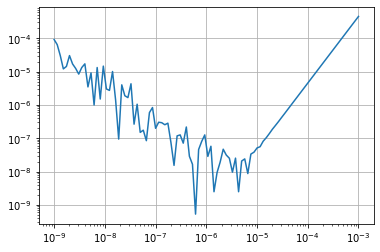

In [4]:
solid.update_def_shape(v)

fd_validation_elastic(solid)

# Validate External Energy Gradient (External Forces) using Finite Differences on External Energy

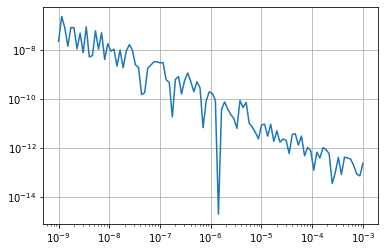

In [5]:
maxX        = torch.max(v[:, 0])
f_point_idx = torch.arange(v.shape[0])[v[:, 0] > maxX - 0.01*aabb[0]]

f_point = torch.zeros(size=(f_point_idx.shape[0], 3))
f_point[:, 2] = -5e3

solid.add_point_load(f_point_idx, f_point)

solid.update_def_shape(v)

fd_validation_ext(solid)

# Validate Elastic Energy Force Differentials (Elastic Forces) using Finite Differences on Elastic Forces

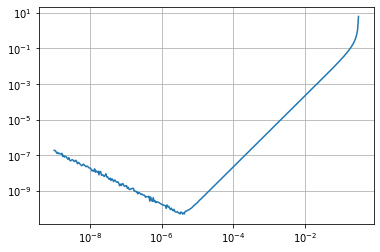

In [6]:
solid.update_def_shape(v)

fd_validation_elastic_differentials(solid)